# Making Plots with JuliaDB and OnlineStats

Plotting in JuliaDB is achieved through [StatPlots.jl](https://github.com/JuliaPlots/StatPlots.jl) and recipes in [OnlineStats](https://github.com/joshday/OnlineStats.jl).

In [28]:
# addprocs()
using JuliaDB, OnlineStats, StatPlots
gr()

Plots.GRBackend()

## Plotting with [StatPlots.jl](https://github.com/JuliaPlots/StatPlots.jl)

All the power and flexibility of [Plots](https://github.com/JuliaPlots/Plots.jl) is made available to JuliaDB with StatPlots and the `@df` macro.

<div class="alert alert-warning">
<strong>Warning!</strong>  StatPlots will not work on distributed table/ndsparse objects.
</div>

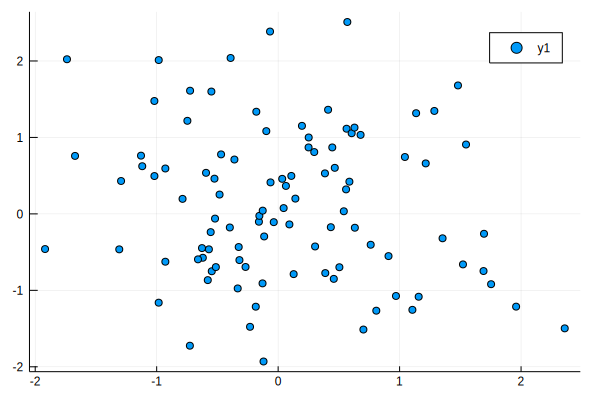

In [29]:
t = table(@NT(x = randn(100), y = randn(100)))

@df t scatter(:x, :y)

## Plotting Big Data with `partitionplot`


Suppose we have a billion observations.  Visualizing a large amount of data is hard on 

1. Your GPU
2. Your Brain

The idea behind `partitionplot` is this:  Instead of plotting individual observations, observations on the x-axis are grouped together and a summary of the data is displayed on the y-axis.  We can then make an easier-to-create/easier-to-comprehend plot.

```
partitionplot(table, [x,] y; stat, nparts)
```

Keyword args:
- `stat`: OnlineStat used to summarize the `y` over a section of `x`
    - Default: `Extrema(Type_of_Y)`
- `nparts`: Number of parts to group `x` into
    - Default: `100`

In [30]:
# diamonds = loadtable("datasets/diamonds.csv"; indexcols = [:carat])
diamonds = loadndsparse("datasets/diamonds.csv"; indexcols = [:carat])

1-d NDSparse with 53940 values (9 field named tuples):
carat │ cut          color  clarity  depth  table  price  x      y      z
──────┼─────────────────────────────────────────────────────────────────────
0.2   │ "Premium"    "E"    "SI2"    60.2   62.0   345    3.79   3.75   2.27
0.2   │ "Premium"    "E"    "VS2"    59.8   62.0   367    3.79   3.77   2.26
0.2   │ "Premium"    "E"    "VS2"    59.0   60.0   367    3.81   3.78   2.24
0.2   │ "Premium"    "E"    "VS2"    61.1   59.0   367    3.81   3.78   2.32
0.2   │ "Premium"    "E"    "VS2"    59.7   62.0   367    3.84   3.8    2.28
0.2   │ "Ideal"      "E"    "VS2"    59.7   55.0   367    3.86   3.84   2.3
0.2   │ "Premium"    "F"    "VS2"    62.6   59.0   367    3.73   3.71   2.33
0.2   │ "Ideal"      "D"    "VS2"    61.5   57.0   367    3.81   3.77   2.33
0.2   │ "Very Good"  "E"    "VS2"    63.4   59.0   367    3.74   3.71   2.36
0.2   │ "Ideal"      "E"    "VS2"    62.2   57.0   367    3.76   3.73   2.33
0.2   │ "Premium"    "D" 

### If only one selection is provided, the x axis is "Number of Observations"

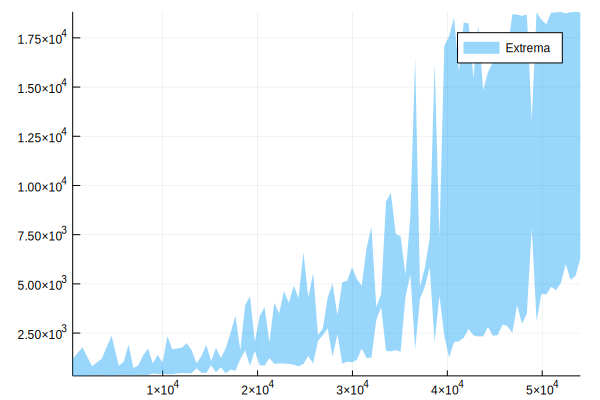

In [31]:
partitionplot(diamonds, :price)

### If two selections are provided (X and Y)

- X will be adaptively grouped together
- The `stat` of Y will be plotted over each group of X

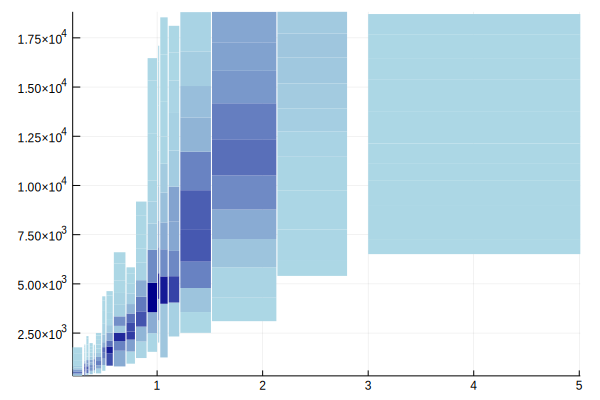

In [32]:
partitionplot(diamonds, :carat, :price; stat=Hist(10), color=:blues, nparts=20)

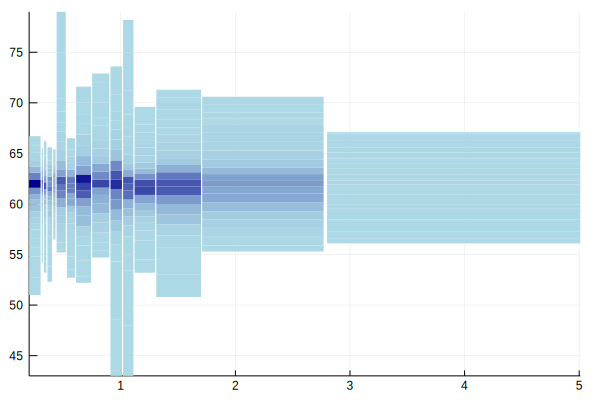

In [33]:
partitionplot(diamonds, :carat, :depth, stat=Hist(20), nparts=15, color=:blues)

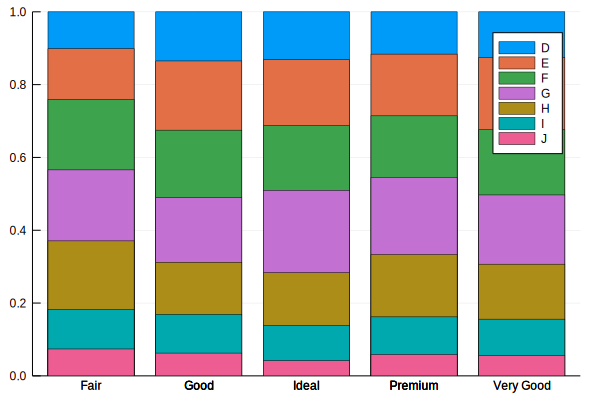

In [34]:
partitionplot(diamonds, :cut, :color, stat=CountMap(String))

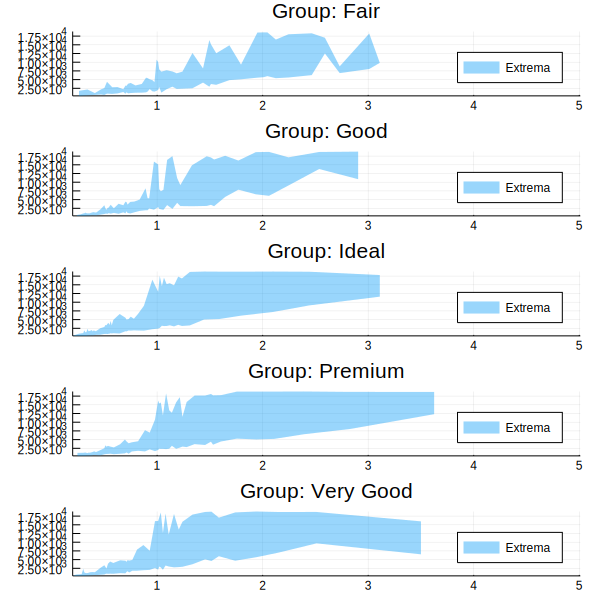

In [35]:
partitionplot(diamonds, :carat, :price, by=:cut, stat=Extrema(), nparts=50,
    layout=(5,1), link = :all, size=(600,600))

# Missing Data

<div class="alert alert-warning">
<strong>Warning!</strong>  <code>partitionplot</code> automatically skips missing values!
</div>

In [36]:
using DataValues
t = table(DataValueArray(randn(10^6), rand(Bool, 10^6)), randn(10^6))

Table with 1000000 rows, 2 columns:
1          2
─────────────────────
#NA        0.0435498
-0.572795  0.157964
1.13378    0.00433038
-0.673726  -0.162079
#NA        1.23073
0.546082   -1.79376
-0.55569   0.956559
#NA        0.555797
-0.353256  0.439972
1.31603    0.663333
#NA        0.194249
#NA        -2.65223
⋮
-0.376102  2.22455
#NA        -0.612487
-0.898979  0.905879
#NA        -0.0230151
0.31914    1.0915
1.6355     -1.31147
#NA        0.0632308
#NA        0.434816
#NA        0.567866
0.660259   -1.14475
#NA        -0.771667

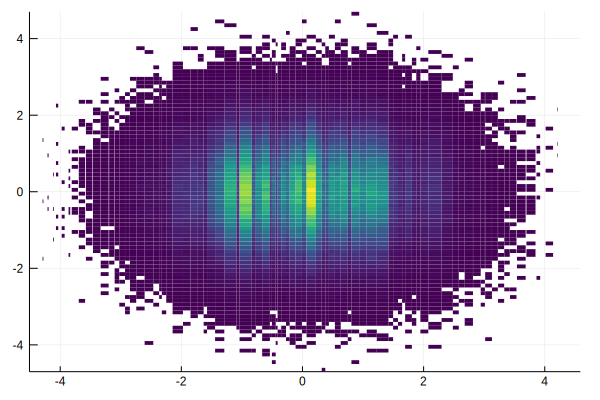

In [37]:
partitionplot(t, 1, 2, stat = Hist(-5:.1:5), color = :viridis)

# Mosaic Plot

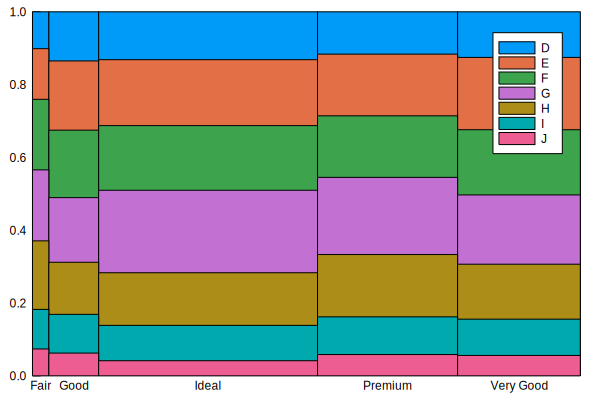

In [38]:
plot(reduce(Mosaic(String,String), diamonds, select = (:cut, :color)))

# PlotNN (plot a numerical X vs. numerical Y)

```
PlotNN(nbins)
```

- Approximate scatterplot 

<div class="alert alert-warning">
<strong>Warning!</strong>  The current implementation is quite slow!  <code>partitionplot</code> with <code>stat=Hist(...)</code> is a better option.
</div>

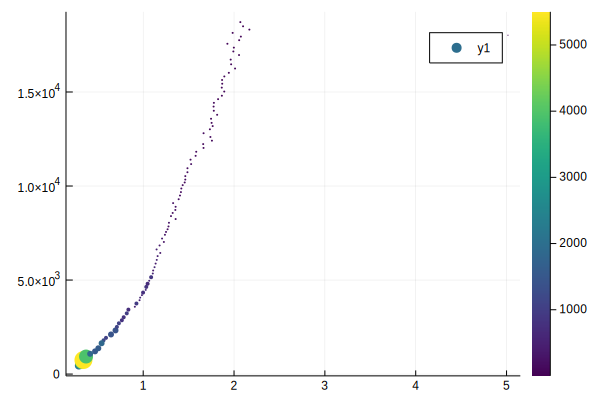

In [39]:
plot(reduce(PlotNN(100), diamonds, select = (:carat, :price)))